<a href="https://colab.research.google.com/github/KarolineCostadaSilva/curso_fotografia_computacional/blob/main/Semana%203/05_Atividade_pratica_Processamento_de_imagem_RAW_%2B_balan%C3%A7o_de_branco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de imagem RAW

In [ ]:
!git clone https://github.com/kevinruiz182/image_processing_tools.git

fatal: destination path 'image_processing_tools' already exists and is not an empty directory.


## I. Bibliotecas e métodos

As linhas abaixo importam algumas bibliotecas python desenvolvidas para processamento de imagens.

"rawpy" é um wrapper Python fácil de usar para a biblioteca LibRaw.
https://pypi.org/project/rawpy/

In [ ]:
!pip install rawpy

In [ ]:
## Mathmatics libraries
import numpy as np
import math
import cv2

## Image Processing libraries
import skimage
from skimage import exposure

import rawpy
import imageio

## Visual and plotting libraries
import matplotlib.pyplot as plt

## II. Lendo uma imagem RAW (CR2)

O arquivo CR2 significa Canon Raw Image, que não é uma imagem raw pura, mas também inclui alguns metadados. Existem muitos códigos já implementados para ler dados inatos em Python e, no caso de um arquivo CR2, para analisar seus metadados. O código implementado aqui é baseado em https://stackoverflow.com/questions/2422050/raw-image-processing-in-python.

In [ ]:
with rawpy.imread('image_processing_tools/images/raw_images/raw_landscape.cr2') as raw:
    rgbImg = raw.postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)

In [ ]:
# Extract Red, Green and Blue channels and save as separate files
R = rgbImg[:,:,0]
G = rgbImg[:,:,1]
B = rgbImg[:,:,2]

Aqui a imagem já foi lida. É interessante notar que no processamento de imagens uma imagem é considerada uma matriz. Em python, a maneira mais simples de representá-lo é usando um tipo numpy.array, conforme confirmado abaixo:

In [ ]:
print(type(rgbImg))
print(rgbImg.dtype)
print(rgbImg[0][0][0])
print(rgbImg.shape)

<class 'numpy.ndarray'>
uint16
2903
(3178, 4770, 3)


In [ ]:
def basic_showImg(img, size=4):
    '''Shows an image in a numpy.array type. Syntax:
        basic_showImg(img, size=4), where
            img = image numpy.array;
            size = the size to show the image. Its value is 4 by default.
    '''
    # Normalize the array
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap='gray')
    plt.show()

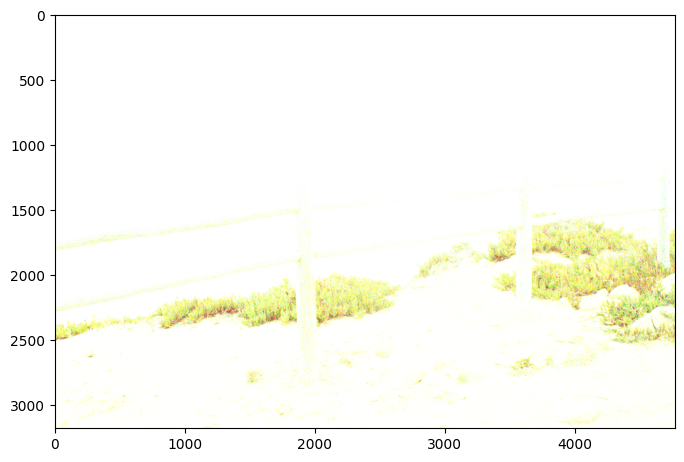

In [ ]:
basic_showImg(rgbImg,8)

## III. Edição de exposição

### Correção de gama

O código nesta seção realiza o ajuste gama usando a biblioteca scikit-image. Uma breve explicação sobre o atributo gama nas imagens pode ser encontrada em https://en.wikipedia.org/wiki/Gamma_correction. Em geral, valores gama maiores que 1 deslocarão o histograma da imagem para a esquerda e a imagem de saída será mais escura que a imagem de entrada. Por outro lado, para valores gama inferiores a 1, o histograma se deslocará para a direita e a imagem de saída será mais brilhante que a imagem de entrada.

In [ ]:
# Ajuste gama
gamma_corrected = exposure.adjust_gamma(rgbImg, gamma=0.5, gain=1)

In [ ]:
gamma_corrected.shape

(3178, 4770, 3)

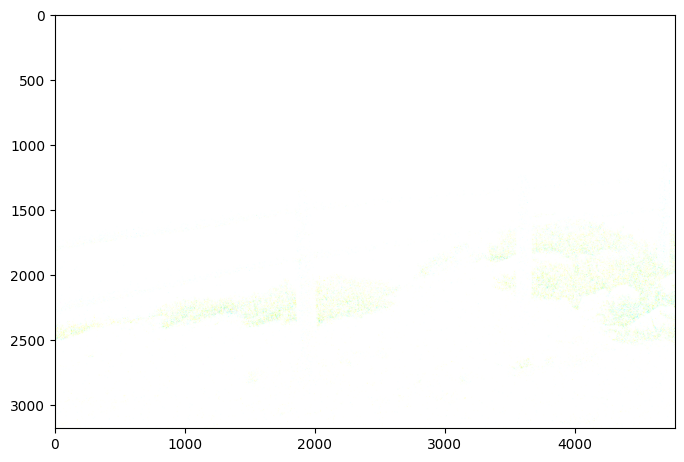

In [ ]:
basic_showImg(gamma_corrected,8)

## V. Equalização do histograma

A equalização do histograma geralmente é aplicada para ajustar o contraste de uma determinada imagem antes de outras edições ou processamentos. Existem muitas técnicas para lidar com imagens RGB ou imagens em escala de cinza. Neste exemplo não levaremos isso em consideração, aplicando a equalização do histograma para uma imagem achatada (ou seja, todos os três canais combinados). Mais detalhes podem ser encontrados em https://en.wikipedia.org/wiki/Histogram_equalization.

In [ ]:
# Equalização do histograma
hist_equalized = exposure.equalize_hist(rgbImg)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


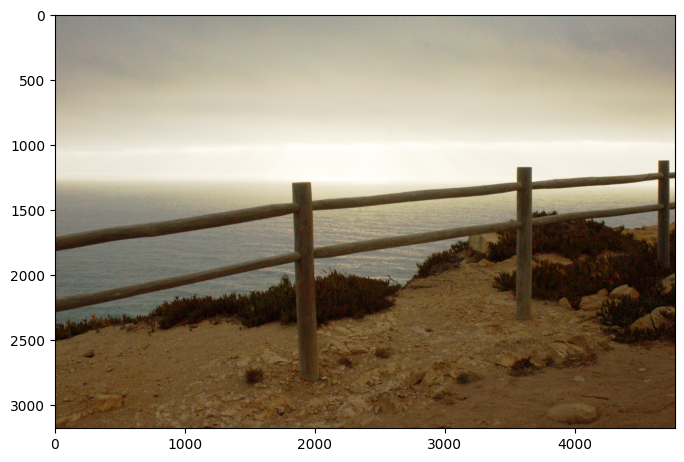

In [ ]:
basic_showImg(hist_equalized,8)

In [ ]:
# Converter o tipo da imagem float64 para uint8
hist_equalized = hist_equalized * 255
hist_equalized = hist_equalized.astype(np.uint8)

### IV. Balanço de branco baseado em algoritmo: Gray-world

*   Vamos converter a imagem para o espaço de cores LAB: L para luminosidade, A para Vermelho/Verde e B para Azul/Amarelo
*   Calcularemos os valores médios das cores nos canais A e B.
*   Em seguida, subtraia 128 (cinza médio) das médias e normalize o canal L por multiplicando por essa diferença.
*   Finalmente, subtraia este valor dos canais A e B.

Você pode adicionar um fator de multiplicação para aumentar/diminuir o brilho geral de cada um dos canais A ou B. (Neste caso, adicionamos 1,2 como multiplicador)


In [ ]:
def GW_white_balance(img):
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(img_LAB[:, :, 1])
    avg_b = np.average(img_LAB[:, :, 2])
    img_LAB[:, :, 1] = img_LAB[:, :, 1] - ((avg_a - 128) * (img_LAB[:, :, 0] / 255.0) * 1.2)
    img_LAB[:, :, 2] = img_LAB[:, :, 2] - ((avg_b - 128) * (img_LAB[:, :, 0] / 255.0) * 1.2)
    balanced_image = cv2.cvtColor(img_LAB, cv2.COLOR_LAB2BGR)
    return balanced_image

image_gw_balanced = GW_white_balance(hist_equalized)

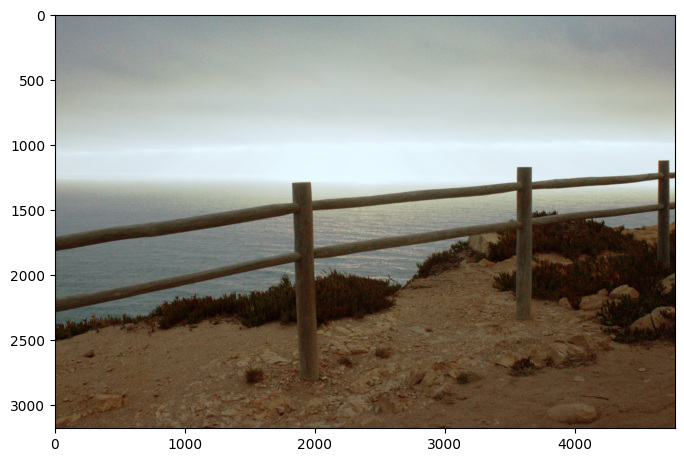

In [ ]:
basic_showImg(image_gw_balanced,8)

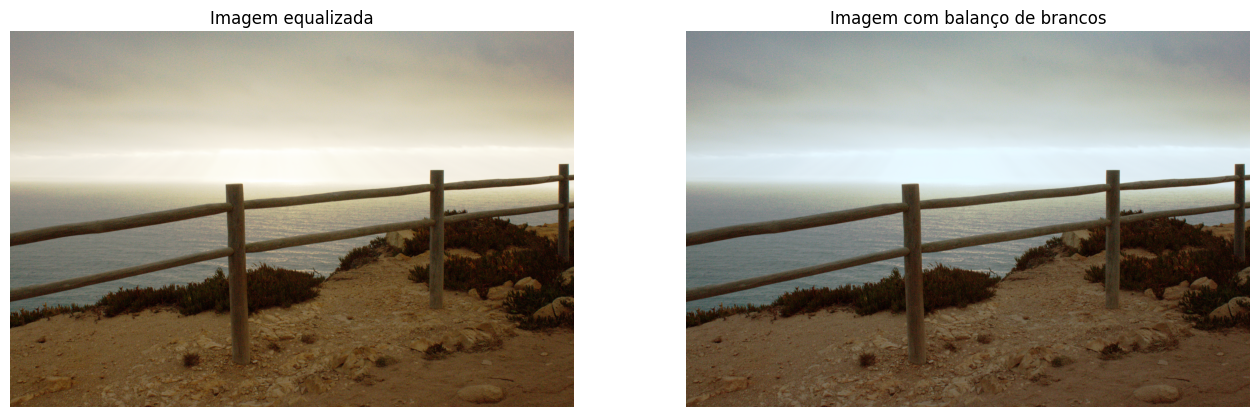

In [ ]:
 # Create a figure with 1 row and 2 columns
plt.figure(figsize=(16, 8))

# Show first image
plt.subplot(1, 2, 1) # 1 row, 2 columns, position 1
plt.imshow(hist_equalized, cmap='gray')
plt.title("Imagem equalizada")
plt.axis('off')  # Turn off axis numbers and labels

# Show second image
plt.subplot(1, 2, 2) # 1 row, 2 columns, position 2
plt.imshow(image_gw_balanced, cmap='gray')
plt.title("Imagem com balanço de brancos")
plt.axis('off')  # Turn off axis numbers and labels

plt.show()

### V. Exportando uma imagem

Terminada a edição, podemos exportar sua imagem para diversos formatos. Existem diversas bibliotecas para isso. neste caso usaremos imageio pois ele suporta diversos formatos de imagem, conforme detalhado em http://imageio.readthedocs.io/en/stable/formats.html.

In [ ]:
def basic_writeImg(directory, filename, img):
    imageio.imwrite(directory+filename, img)

In [ ]:
basic_writeImg('','edited_img.png', image_gw_balanced)

**Source:** https://www.kaggle.com/code/tsilveira/raw-image-processing